# Описание проекта
Спрогнозировать количество заказов таксиd в аэропорт на следующий час, на основании сгенерированных данных.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('./Downloads/taxi.csv', index_col=[0], parse_dates=[0])
print('Размер датасета', df.shape)
df

Размер датасета (26496, 1)


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [ ]:
# check monotoneness
print(df.index.is_monotonic)

True


In [ ]:
#make resample 1 hour
df = df.resample('1H').sum()
print(df.shape)
df

(4416, 1)


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [ ]:
#make a hist
def graf(data, title, xlabel):
    plt.figure(figsize=(12,4), dpi=80)
    data.plot(ax=plt.gca())
    plt.title(title)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Количество заказов', fontsize=12)
    plt.show()

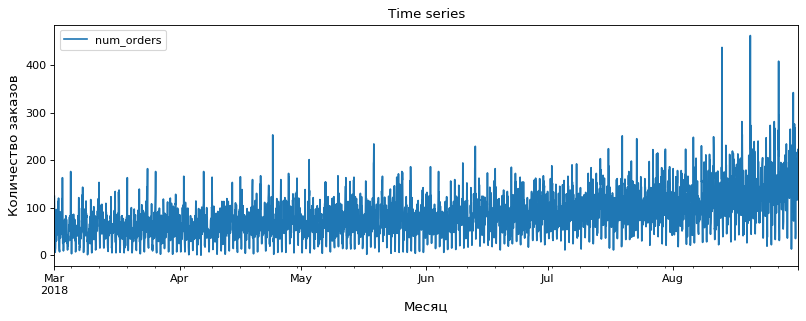

In [ ]:
graf(df, 'Time series', 'Месяц')

In [ ]:
decomposed = seasonal_decompose(df)

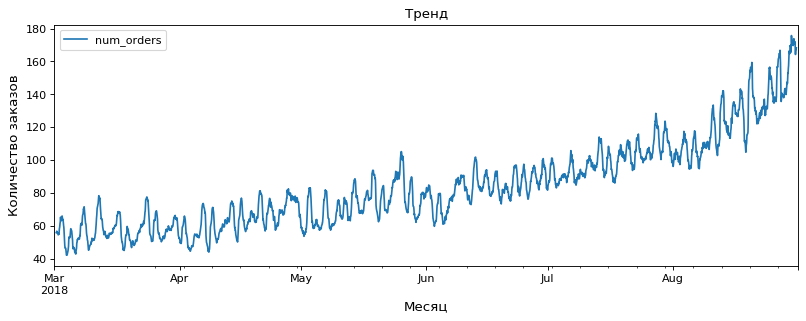

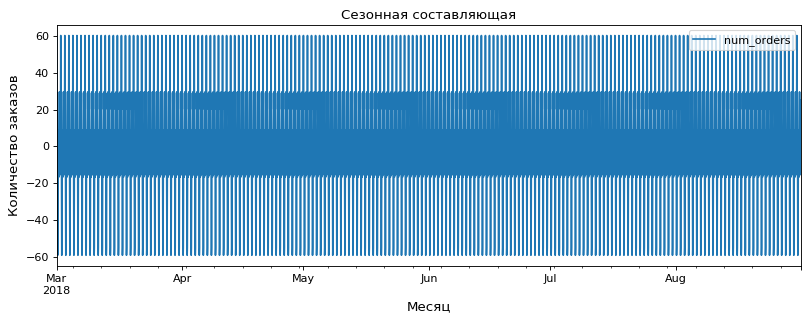

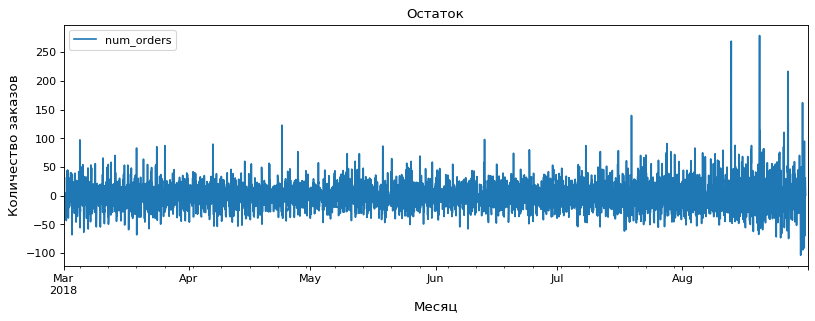

In [ ]:
graf(decomposed.trend, 'Тренд', 'Месяц')

graf(decomposed.seasonal, 'Сезонная составляющая', 'Месяц')

graf(decomposed.resid, 'Остаток', 'Месяц')

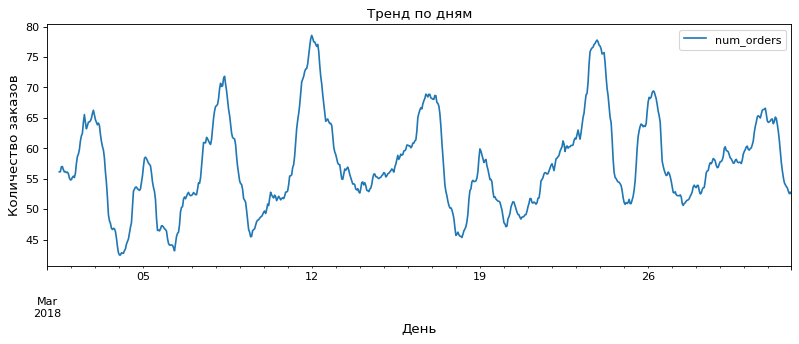

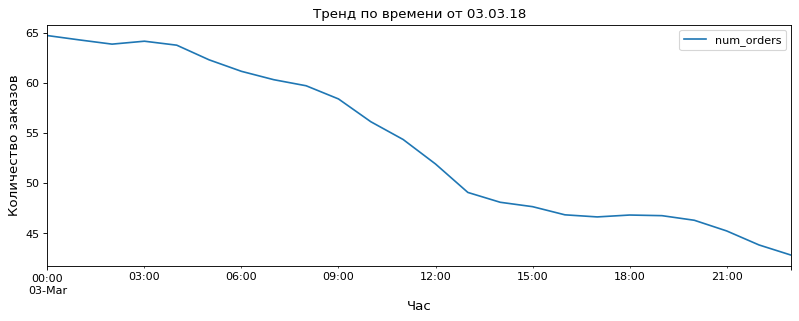

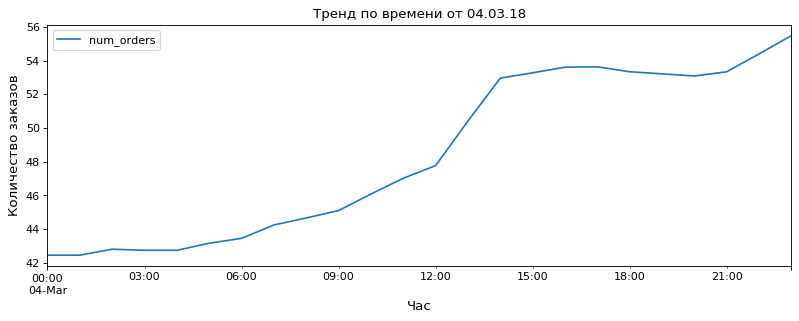

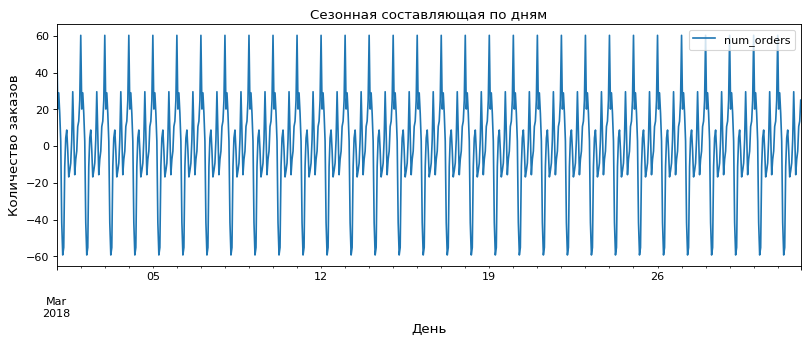

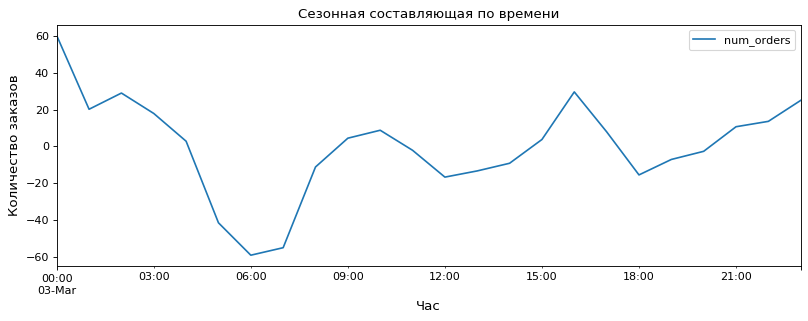

In [ ]:
graf(decomposed.trend['2018-03-01':'2018-03-31'] , 'Тренд по дням', 'День')
graf(decomposed.trend['2018-03-03 00:00:00':'2018-03-03 23:00:00'] , 'Тренд по времени от 03.03.18', 'Час')
graf(decomposed.trend['2018-03-04 00:00:00':'2018-03-04 23:00:00'] , 'Тренд по времени от 04.03.18', 'Час')

graf(decomposed.seasonal['2018-03-01':'2018-03-31'], 'Сезонная составляющая по дням', 'День')
graf(decomposed.seasonal['2018-03-03 00:00:00':'2018-03-03 23:00:00'], 'Сезонная составляющая по времени', 'Час')

In [ ]:
# make df
def make_score(data, rolling_mean_size, lag):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    for i in range(1, lag+1):
        data['lag_{}'.format(i)] = data['num_orders'].shift(i)
        
    return data

In [ ]:
df = make_score(df, 1, 24)
print(df.info())
print()
df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 30 columns):
num_orders      4416 non-null int64
month           4416 non-null int64
day             4416 non-null int64
day_of_week     4416 non-null int64
hour            4416 non-null int64
rolling_mean    4415 non-null float64
lag_1           4415 non-null float64
lag_2           4414 non-null float64
lag_3           4413 non-null float64
lag_4           4412 non-null float64
lag_5           4411 non-null float64
lag_6           4410 non-null float64
lag_7           4409 non-null float64
lag_8           4408 non-null float64
lag_9           4407 non-null float64
lag_10          4406 non-null float64
lag_11          4405 non-null float64
lag_12          4404 non-null float64
lag_13          4403 non-null float64
lag_14          4402 non-null float64
lag_15          4401 non-null float64
lag_16          4400 non-null float64
lag_17          4399 no

,num_orders,month,day,day_of_week,hour,rolling_mean,lag_1,lag_2,lag_3,lag_4,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,207.0,217.0,197.0,116.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0
2018-08-31 20:00:00,154,8,31,4,20,136.0,136.0,207.0,217.0,197.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0
2018-08-31 21:00:00,159,8,31,4,21,154.0,154.0,136.0,207.0,217.0,...,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0


In [ ]:
# drop missing values
df = df.dropna()
# drop 1 day as not fully recorded
df_new = df['2018-03-02':]

df_new

features = df_new.drop('num_orders', axis=1)
target = df_new['num_orders']

features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              shuffle=False, 
                                                                              test_size=0.2)

features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            shuffle=False, 
                                                                            test_size = 0.5)

In [ ]:
# train LR
%%time

reg_model = LinearRegression()
reg_model.fit(features_train, target_train)
reg_prediction = reg_model.predict(features_valid)
RMSE = mean_squared_error(target_valid, reg_prediction)**0.5
print('RMSE Линейной регрессии = ', RMSE)
print()

RMSE Линейной регрессии =  34.228088314146405

CPU times: user 27.8 ms, sys: 4.02 ms, total: 31.8 ms
Wall time: 8.13 ms


In [ ]:
# train RF
%%time

forest_model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=42)
forest_model.fit(features_train, target_train)
forest_prediction = forest_model.predict(features_valid)
RMSE = mean_squared_error(target_valid, forest_prediction)**0.5
print('RMSE Леса регрессии = ', RMSE)
print()

RMSE Леса регрессии =  32.41441064056847

CPU times: user 1min, sys: 320 ms, total: 1min 1s
Wall time: 1min 1s


**3. CatBoost**

In [ ]:
# train CB
%%time

catboost_model = CatBoostRegressor(eval_metric="RMSE", 
                                   n_estimators=500, 
                                   max_depth=8, 
                                   learning_rate=0.15, 
                                   leaf_estimation_method='Gradient', 
                                   random_state=42)

catboost_model.fit(features_train, target_train, verbose=100)
prediction = catboost_model.predict(features_valid)
RMSE = mean_squared_error(target_valid, prediction)**0.5
print('RMSE CatBoost = ', RMSE)
print()

0:	learn: 33.2062705	total: 56.1ms	remaining: 28s
100:	learn: 13.6330996	total: 6s	remaining: 23.7s
200:	learn: 9.0584655	total: 11.9s	remaining: 17.8s
300:	learn: 6.3946791	total: 17.8s	remaining: 11.8s
400:	learn: 4.4764716	total: 23.7s	remaining: 5.84s
499:	learn: 3.0840358	total: 29.7s	remaining: 0us
RMSE CatBoost =  31.621482238026502

CPU times: user 27 s, sys: 2.91 s, total: 30 s
Wall time: 33.3 s


In [ ]:
# check on test 
test_pred = reg_model.predict(features_test)
rmse = mean_squared_error(target_test, test_pred)**0.5
print('RMSE Линейной регрессии', rmse)

test_pred = forest_model.predict(features_test)
rmse = mean_squared_error(target_test, test_pred)**0.5
print('RMSE Леса регрессии', rmse)

test_pred = catboost_model.predict(features_test)
rmse = mean_squared_error(target_test, test_pred)**0.5
print('RMSE CatBoost', rmse)

RMSE Линейной регрессии 46.543823966417904
RMSE Леса регрессии 49.10836399484308
RMSE CatBoost 52.25156922340082


### Вывод:

Наименьшая ошика у линейной регрессии, однако следует учест, что предскаазне делалось на небольшом объеме данных.